In [1]:
import matplotlib.pyplot as plt

from utils import data_loader

import os
import sys
import pathlib

import numpy as np

from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import expand_labels

ROOT_PATH = str(pathlib.Path().absolute())
DATA_STORAGE_PATH = '/data_storage/'
STORAGE_PATH = ROOT_PATH + DATA_STORAGE_PATH

DATASET_PATH = '/datasets/final_data'
FINAL_DATASET_PATH = ROOT_PATH + DATASET_PATH

TRAIN_PATH_IMAGES = FINAL_DATASET_PATH + '/train/images/'
TEST_PATH_IMAGES = FINAL_DATASET_PATH + '/test/images/'
VALI_PATH_IMAGES = FINAL_DATASET_PATH + '/validation/images/'

TRAIN_PATH_MASKS = FINAL_DATASET_PATH + '/train/masks/'
TEST_PATH_MASKS = FINAL_DATASET_PATH + '/test/masks/'
VALI_PATH_MASKS = FINAL_DATASET_PATH + '/validation/masks/'

In [2]:
train_data = data_loader.load_train_data('final_data', is_dots_expanded=False, expand_size=1)
test_data = data_loader.load_test_data('final_data', is_dots_expanded=False, expand_size=1)

In [3]:
imr = imread('./examples/image8004.jpg')

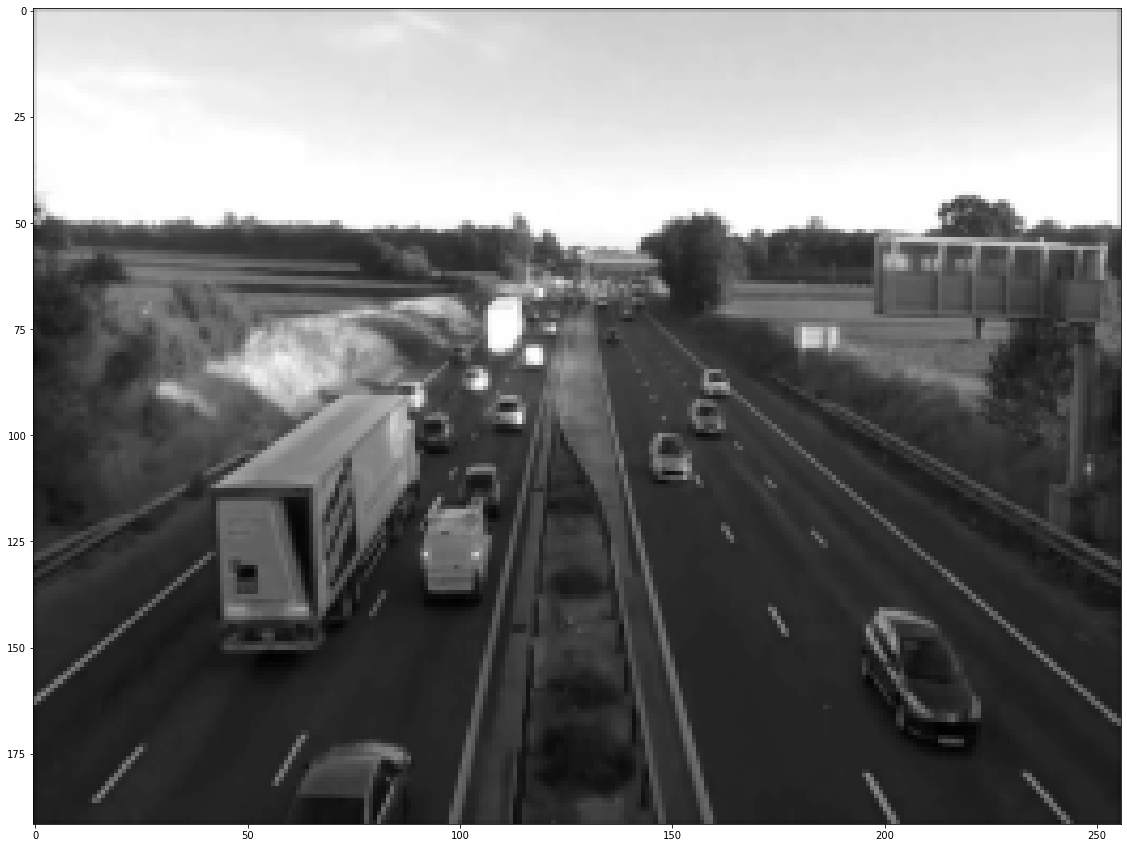

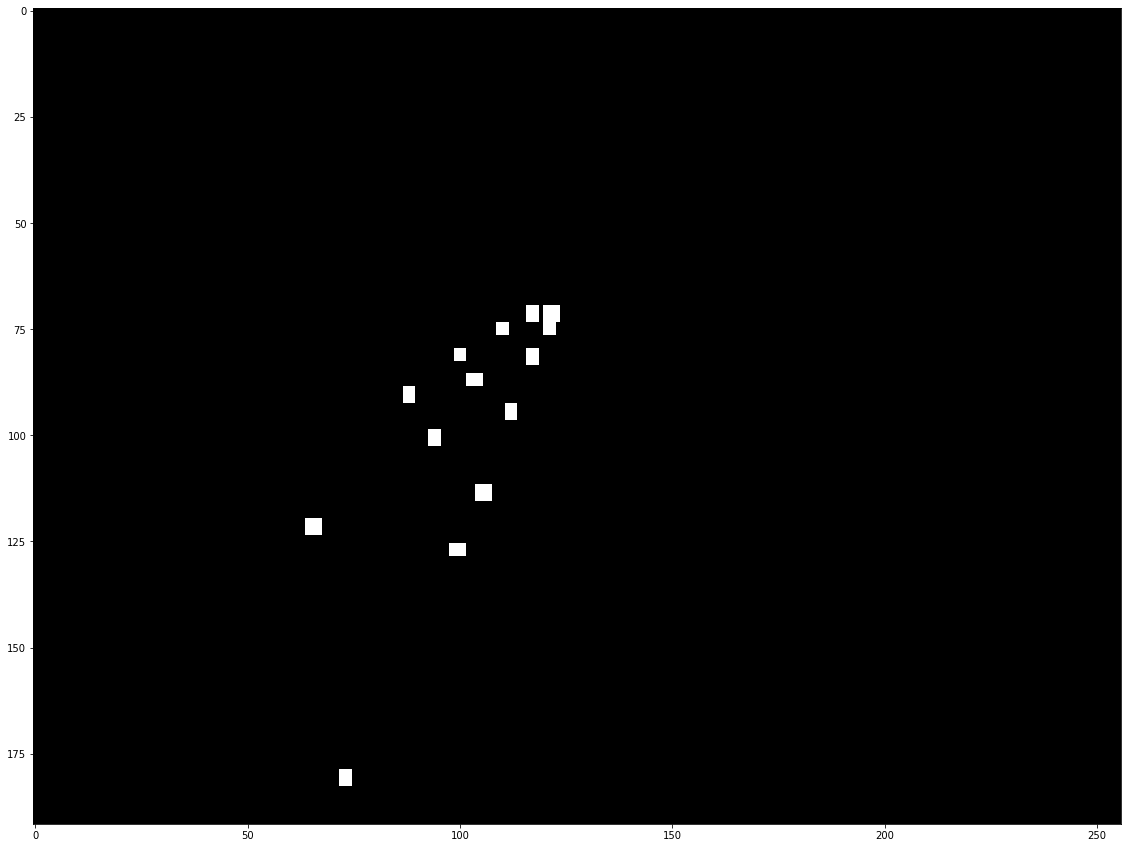

In [17]:
s1 = train_data['train_data'][7]
l1 = train_data['train_label_data'][7]

plt.figure(figsize=(30, 15))
plt.imshow(s1, cmap='gray')
plt.show()

plt.figure(figsize=(30, 15))
plt.imshow(l1, cmap='gray')
plt.show()

In [10]:
s1_mean = (s1 - s1.mean()) / s1.std()

In [11]:
s1_mean

array([[[ 0.85691807],
        [ 1.13198444],
        [ 1.14448746],
        ...,
        [ 0.96944522],
        [ 0.96944522],
        [ 0.71938489]],

       [[ 1.09447539],
        [ 1.39454779],
        [ 1.41955382],
        ...,
        [ 1.21950556],
        [ 1.21950556],
        [ 0.94443919]],

       [[ 1.11948142],
        [ 1.41955382],
        [ 1.43205684],
        ...,
        [ 1.24451159],
        [ 1.24451159],
        [ 0.96944522]],

       ...,

       [[-0.95601934],
        [-0.90600727],
        [-0.90600727],
        ...,
        [-0.8559952 ],
        [-0.86849822],
        [-0.94351632]],

       [[-0.96852235],
        [-0.90600727],
        [-0.91851029],
        ...,
        [-0.8559952 ],
        [-0.86849822],
        [-0.94351632]],

       [[-1.0060314 ],
        [-0.95601934],
        [-0.95601934],
        ...,
        [-0.90600727],
        [-0.91851029],
        [-0.99352839]]])

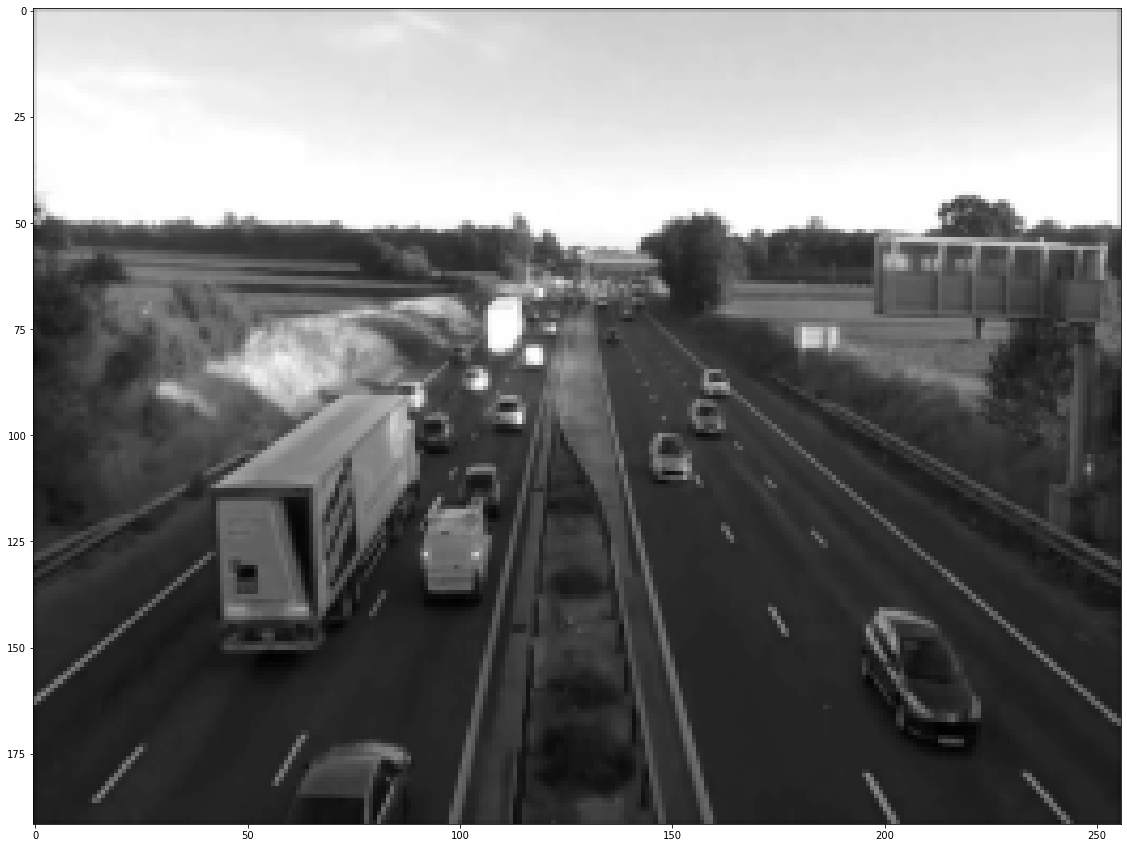

In [12]:
plt.figure(figsize=(30, 15))
plt.imshow(s1_mean, cmap='gray')
plt.show()

In [31]:
imr.shape

(1080, 1920, 3)

In [34]:
s1.shape

(96, 128, 1)

In [15]:
l1_s = l1.reshape(192, 256)

In [16]:
l1_s

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])